In [78]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, QuantumCircuit, Aer, execute
from qiskit.circuit.library import IntegerComparator
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem

In [151]:
# set problem parameters
n_z = 4
z_max = 4
z_values = np.linspace(-z_max, z_max, 2 ** n_z)
p_zeros = [0.15, 0.25, 0.1, 0.2]
rhos = [0.1, 0.05, 0.05, 0.1]
lgd = [1, 2, 1, 2]
K = len(p_zeros)
alpha = 0.1

In [152]:
from qiskit_finance.circuit.library import GaussianConditionalIndependenceModel as GCI

u = GCI(n_z, z_max, p_zeros, rhos)

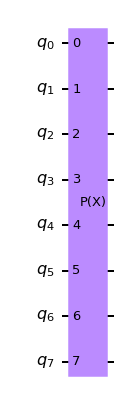

In [153]:
u.draw()

In [154]:
# run the circuit and analyze the results
job = execute(u, backend=Aer.get_backend("statevector_simulator"))

In [155]:
# analyze uncertainty circuit and determine exact solutions
p_z = np.zeros(2 ** n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = u.num_qubits
state = job.result().get_statevector()
if not isinstance(state, np.ndarray):
    state = state.data
for i, a in enumerate(state):

    # get binary representation
    b = ("{0:0%sb}" % num_qubits).format(i)
    prob = np.abs(a) ** 2

    # extract value of Z and corresponding probability
    i_normal = int(b[-n_z:], 2)
    p_z[i_normal] += prob

    # determine overall default probability for k
    loss = 0
    for k in range(K):
        if b[K - k - 1] == "1":
            p_default[k] += prob
            loss += lgd[k]
    values += [loss]
    probabilities += [prob]

values = np.array(values)
probabilities = np.array(probabilities)

expected_loss = np.dot(values, probabilities)

losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

i_var = np.argmax(cdf >= 1 - alpha)
exact_var = losses[i_var]
exact_cvar = np.dot(pdf[(i_var + 1) :], losses[(i_var + 1) :]) / sum(pdf[(i_var + 1) :])

In [156]:
print("Expected Loss E[L]:                %.4f" % expected_loss)
print("Value at Risk VaR[L]:              %.4f" % exact_var)
print("P[L <= VaR[L]]:                    %.4f" % cdf[exact_var])
print("Conditional Value at Risk CVaR[L]: %.4f" % exact_cvar)

Expected Loss E[L]:                1.1306
Value at Risk VaR[L]:              3.0000
P[L <= VaR[L]]:                    0.9384
Conditional Value at Risk CVaR[L]: 4.2862


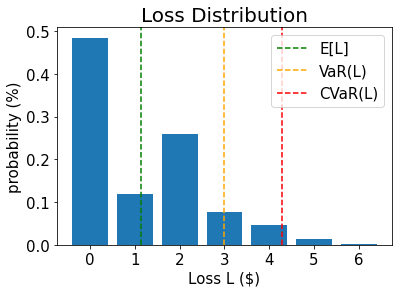

In [157]:
# plot loss PDF, expected loss, var, and cvar
plt.bar(losses, pdf)
plt.axvline(expected_loss, color="green", linestyle="--", label="E[L]")
plt.axvline(exact_var, color="orange", linestyle="--", label="VaR(L)")
plt.axvline(exact_cvar, color="red", linestyle="--", label="CVaR(L)")
plt.legend(fontsize=15)
plt.xlabel("Loss L ($)", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Loss Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

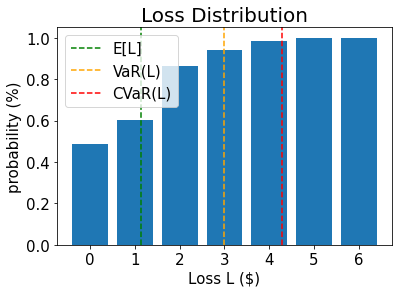

In [158]:
# plot loss PDF, expected loss, var, and cvar
plt.bar(losses, cdf)
plt.axvline(expected_loss, color="green", linestyle="--", label="E[L]")
plt.axvline(exact_var, color="orange", linestyle="--", label="VaR(L)")
plt.axvline(exact_cvar, color="red", linestyle="--", label="CVaR(L)")
plt.legend(fontsize=15)
plt.xlabel("Loss L ($)", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Loss Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

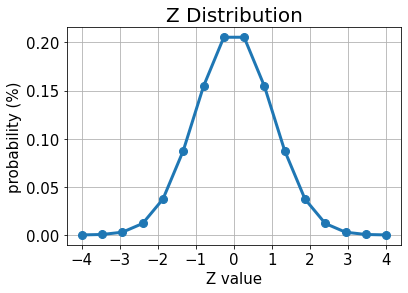

In [159]:
# plot results for Z
plt.plot(z_values, p_z, "o-", linewidth=3, markersize=8)
plt.grid()
plt.xlabel("Z value", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Z Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

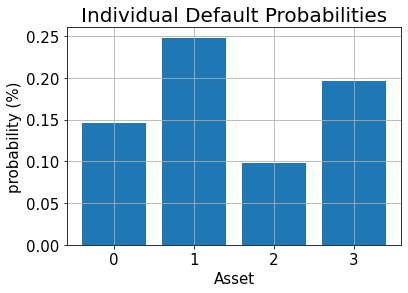

In [160]:

# plot results for default probabilities
plt.bar(range(K), p_default)
plt.xlabel("Asset", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Individual Default Probabilities", size=20)
plt.xticks(range(K), size=15)
plt.yticks(size=15)
plt.grid()
plt.show()

In [161]:
# add Z qubits with weight/loss 0
from qiskit.circuit.library import WeightedAdder

agg = WeightedAdder(n_z + K, [0] * n_z + lgd)
print(n_z + K, [0] * n_z + lgd)

8 [0, 0, 0, 0, 1, 2, 1, 2]


In [164]:
from qiskit.circuit.library import LinearAmplitudeFunction

# define linear objective function
breakpoints = [0]
slopes = [1]
offsets = [0]
f_min = 0
f_max = sum(lgd)
c_approx = 0.25

objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slope=slopes,
    offset=offsets,
    # max value that can be reached by the qubit register (will not always be reached)
    domain=(0, 2 ** agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

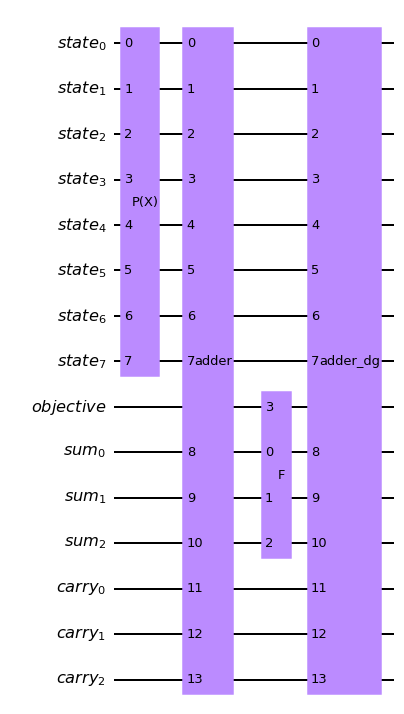

In [166]:
# define the registers for convenience and readability
qr_state = QuantumRegister(u.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits+1, "carry")
qr_obj = QuantumRegister(1, "objective")

# define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name="A")

# load the random variable
state_preparation.append(u.to_gate(), qr_state)

# aggregate
state_preparation.append(agg.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:])

# linear objective function
state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])

# uncompute aggregation
state_preparation.append(agg.to_gate().inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])

# draw the circuit
state_preparation.draw()

In [167]:
job = execute(state_preparation, backend=Aer.get_backend("statevector_simulator"))


In [168]:
# evaluate resulting statevector
value = 0
state = job.result().get_statevector()
if not isinstance(state, np.ndarray):
    state = state.data
for i, a in enumerate(state):
    b = ("{0:0%sb}" % (len(qr_state) + 1)).format(i)[-(len(qr_state) + 1) :]
    am = np.round(np.real(a), decimals=4)
    if np.abs(am) > 1e-6 and b[0] == "1":
        value += am ** 2

print("Exact Expected Loss:   %.4f" % expected_loss)
print("Exact Operator Value:  %.4f" % value)
print("Mapped Operator value: %.4f" % objective.post_processing(value))

Exact Expected Loss:   1.1306
Exact Operator Value:  0.3803
Mapped Operator value: 1.1712


In [171]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=500)
problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[len(qr_state)],
    post_processing=objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
result = ae.estimate(problem)

# print results
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:    \t%.4f" % expected_loss)
print("Estimated value:\t%.4f" % result.estimation_processed)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact value:    	1.1306
Estimated value:	1.1917
Confidence interval: 	[1.1091, 1.2742]


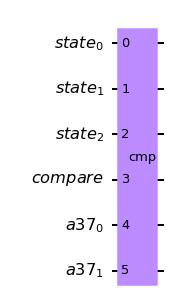

In [178]:
# set x value to estimate the CDF
x_eval = 2

comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)
comparator.draw()

In [189]:
def get_cdf_circuit(x_eval):
    # define the registers for convenience and readability
    qr_state = QuantumRegister(u.num_qubits, "state")
    qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
    qr_carry = QuantumRegister(agg.num_carry_qubits+1, "carry")
    qr_obj = QuantumRegister(1, "objective")
    qr_compare = QuantumRegister(1, "compare")

    # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name="A")

    # load the random variable
    state_preparation.append(u, qr_state)

    # aggregate
    state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:])

    # comparator objective function
    comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)
    state_preparation.append(comparator, qr_sum[:] + qr_obj[:] + qr_carry[-2:] )

    # uncompute aggregation
    state_preparation.append(agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])

    return state_preparation


state_preparation = get_cdf_circuit(x_eval)

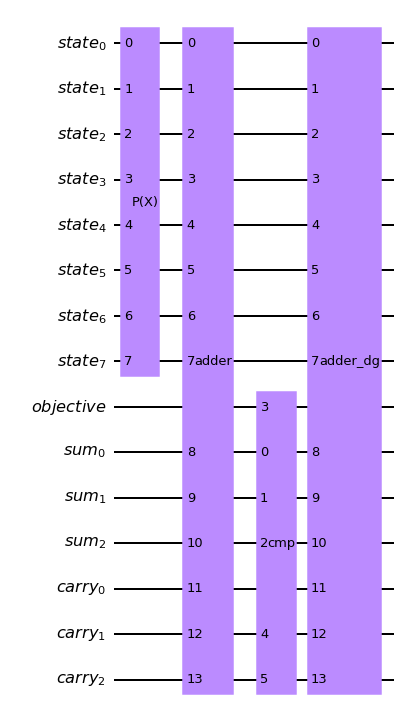

In [190]:
job = execute(state_preparation, backend=Aer.get_backend("statevector_simulator"))
state_preparation.draw()

In [191]:
# evaluate resulting statevector
var_prob = 0
state = job.result().get_statevector()
if not isinstance(state, np.ndarray):
    state = state.data
for i, a in enumerate(state):
    b = ("{0:0%sb}" % (len(qr_state) + 1)).format(i)[-(len(qr_state) + 1) :]
    prob = np.abs(a) ** 2
    if prob > 1e-6 and b[0] == "1":
        var_prob += prob
print("Operator CDF(%s)" % x_eval + " = %.4f" % var_prob)
print("Exact    CDF(%s)" % x_eval + " = %.4f" % cdf[x_eval])

Operator CDF(2) = 0.8617
Exact    CDF(2) = 0.8617


In [192]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = EstimationProblem(state_preparation=state_preparation, objective_qubits=[len(qr_state)])
# construct amplitude estimation
ae_cdf = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
result_cdf = ae_cdf.estimate(problem)

# print results
conf_int = np.array(result_cdf.confidence_interval)
print("Exact value:    \t%.4f" % cdf[x_eval])
print("Estimated value:\t%.4f" % result_cdf.estimation)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact value:    	0.8617
Estimated value:	0.8602
Confidence interval: 	[0.8571, 0.8633]


In [193]:
def run_ae_for_cdf(x_eval, epsilon=0.01, alpha=0.05, simulator="aer_simulator"):

    # construct amplitude estimation
    state_preparation = get_cdf_circuit(x_eval)
    qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
    problem = EstimationProblem(
        state_preparation=state_preparation, objective_qubits=[len(qr_state)]
    )
    ae_var = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
    result_var = ae_var.estimate(problem)

    return result_var.estimation

In [194]:
def bisection_search(
    objective, target_value, low_level, high_level, low_value=None, high_value=None
):
    """
    Determines the smallest level such that the objective value is still larger than the target
    :param objective: objective function
    :param target: target value
    :param low_level: lowest level to be considered
    :param high_level: highest level to be considered
    :param low_value: value of lowest level (will be evaluated if set to None)
    :param high_value: value of highest level (will be evaluated if set to None)
    :return: dictionary with level, value, num_eval
    """

    # check whether low and high values are given and evaluated them otherwise
    print("--------------------------------------------------------------------")
    print("start bisection search for target value %.3f" % target_value)
    print("--------------------------------------------------------------------")
    num_eval = 0
    if low_value is None:
        low_value = objective(low_level)
        num_eval += 1
    if high_value is None:
        high_value = objective(high_level)
        num_eval += 1

    # check if low_value already satisfies the condition
    if low_value > target_value:
        return {
            "level": low_level,
            "value": low_value,
            "num_eval": num_eval,
            "comment": "returned low value",
        }
    elif low_value == target_value:
        return {"level": low_level, "value": low_value, "num_eval": num_eval, "comment": "success"}

    # check if high_value is above target
    if high_value < target_value:
        return {
            "level": high_level,
            "value": high_value,
            "num_eval": num_eval,
            "comment": "returned low value",
        }
    elif high_value == target_value:
        return {
            "level": high_level,
            "value": high_value,
            "num_eval": num_eval,
            "comment": "success",
        }

    # perform bisection search until
    print("low_level    low_value    level    value    high_level    high_value")
    print("--------------------------------------------------------------------")
    while high_level - low_level > 1:

        level = int(np.round((high_level + low_level) / 2.0))
        num_eval += 1
        value = objective(level)

        print(
            "%2d           %.3f        %2d       %.3f    %2d            %.3f"
            % (low_level, low_value, level, value, high_level, high_value)
        )

        if value >= target_value:
            high_level = level
            high_value = value
        else:
            low_level = level
            low_value = value

    # return high value after bisection search
    print("--------------------------------------------------------------------")
    print("finished bisection search")
    print("--------------------------------------------------------------------")
    return {"level": high_level, "value": high_value, "num_eval": num_eval, "comment": "success"}

In [195]:
# run bisection search to determine VaR
objective = lambda x: run_ae_for_cdf(x)
bisection_result = bisection_search(
    objective, 1 - alpha, min(losses) - 1, max(losses), low_value=0, high_value=1
)
var = bisection_result["level"]

--------------------------------------------------------------------
start bisection search for target value 0.950
--------------------------------------------------------------------
low_level    low_value    level    value    high_level    high_value
--------------------------------------------------------------------
-1           0.000         2       0.862     6            1.000
 2           0.862         4       0.984     6            1.000
 2           0.862         3       0.940     4            0.984
--------------------------------------------------------------------
finished bisection search
--------------------------------------------------------------------


In [196]:
print("Estimated Value at Risk: %2d" % var)
print("Exact Value at Risk:     %2d" % exact_var)
print("Estimated Probability:    %.3f" % bisection_result["value"])
print("Exact Probability:        %.3f" % cdf[exact_var])

Estimated Value at Risk:  4
Exact Value at Risk:      3
Estimated Probability:    0.984
Exact Probability:        0.938


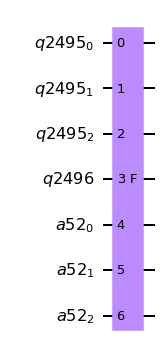

In [197]:
# define linear objective
breakpoints = [0, var]
slopes = [0, 1]
offsets = [0, 0]  # subtract VaR and add it later to the estimate
f_min = 0
f_max = 3 - var
c_approx = 0.25

cvar_objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slopes,
    offsets,
    domain=(0, 2 ** agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

cvar_objective.draw()

In [200]:
# define the registers for convenience and readability
qr_state = QuantumRegister(u.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits+1, "carry")
qr_obj = QuantumRegister(1, "objective")
qr_work = QuantumRegister(cvar_objective.num_ancillas - len(qr_carry), "work")

# define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, qr_work, name="A")

# load the random variable
state_preparation.append(u, qr_state)

# aggregate
state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:])

# linear objective function
state_preparation.append(cvar_objective, qr_sum[:] + qr_obj[:] + qr_carry[:] + qr_work[:])

# uncompute aggregation
state_preparation.append(agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])

In [201]:
job = execute(state_preparation, backend=Aer.get_backend("statevector_simulator"))


In [202]:
# evaluate resulting statevector
value = 0
state = job.result().get_statevector()
if not isinstance(state, np.ndarray):
    state = state.data
for i, a in enumerate(state):
    b = ("{0:0%sb}" % (len(qr_state) + 1)).format(i)[-(len(qr_state) + 1) :]
    am = np.round(np.real(a), decimals=4)
    if np.abs(am) > 1e-6 and b[0] == "1":
        value += am ** 2

# normalize and add VaR to estimate
value = cvar_objective.post_processing(value)
d = 1.0 - bisection_result["value"]
v = value / d if d != 0 else 0
normalized_value = v + var
print("Estimated CVaR: %.4f" % normalized_value)
print("Exact CVaR:     %.4f" % exact_cvar)

Estimated CVaR: 3.8898
Exact CVaR:     4.2862


In [203]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[len(qr_state)],
    post_processing=cvar_objective.post_processing,
)
# construct amplitude estimation
ae_cvar = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
result_cvar = ae_cvar.estimate(problem)

In [204]:
# print results
d = 1.0 - bisection_result["value"]
v = result_cvar.estimation_processed / d if d != 0 else 0
print("Exact CVaR:    \t%.4f" % exact_cvar)
print("Estimated CVaR:\t%.4f" % (v + var))

Exact CVaR:    	4.2862
Estimated CVaR:	3.3532
